# Research the correlation between PFT and Goh scores

In [3]:
import numpy as np
from glob import glob
from skimage.morphology import skeletonize_3d
from medutils.medutils import load_itk, save_itk
import SimpleITK as sitk
import itk
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.morphology import disk,diamond,rectangle,square,erosion,dilation,opening,closing,skeletonize
import pickle
import pandas as pd


I will create a dict including the Goh scores and PFT of each patient.
PFT has 4 absolute values and 4 percentage values, while Goh score has 15 values (TOT, GG, and RET of 5 levels for each case).
so there would be totally 8 * 15 = 120 combinations. 
Wow, its too many!

Because at present I input the whole image to networks, so I think I should use the average of the 5 levels, which means that I have 8 * 3 = 24 combinations.

Furthermore, at present, I only predict the absolute values, so let's see the correlation of the 4 * 3 = 12 combinations.



In [4]:
pft_fpath = '/home/jjia/data/dataset/lung_function/SScBaseline_PFT_anonymized.xlsx'  # id from 0068800 to 99..., total 333 cases
label_excel = pd.read_excel(pft_fpath, engine='openpyxl')
label_excel = label_excel.sort_values(by=['subjectID'])


In [5]:
label_excel

,subjectID,scandate,TLC_Lres,DateDF_abs,ScanDate,PFT Date,Date of Birth,Gender,Age,Height,...,FEV 1 % FVC,FEV 1 % VC,FVC,FVC/pred,FVC/predNew,VC in,TLC_He,TLC/pred,Remarks,"Remarks_Jingnan: yellow means NV, red means ""obtained by guess by JIngnan"""
122,SSc_patient_0068800,20110701,YES,1.0,2011-07-01,2011-06-30,1951-12-07,female,60.0,1.81,...,80.020,75.716,4.363,122.271109,108,4.426,6.261,101.705653,NaN,NaN
123,SSc_patient_0127512,20091127,YES,1.0,2009-11-27,2009-11-26,1931-03-07,female,78.0,1.56,...,75.849,69.643,2.076,104.175030,88,2.129,3.864,85.752330,NaN,NaN
124,SSc_patient_0139552,20121102,YES,1.0,2012-11-02,2012-11-01,1939-06-17,female,73.0,1.71,...,74.090,72.354,3.544,127.148136,115,3.558,5.781,105.185590,NaN,NaN
125,SSc_patient_0143788,20090529,YES,0.0,2009-05-28,2009-05-28,1942-09-12,female,68.0,1.70,...,NaN,80.370,2.860,98.000000,87,2.820,3.970,73.000000,Geen FEV1/FVC,NaN
126,SSc_patient_0152440,20100604,YES,1.0,2010-06-04,2010-06-03,1946-12-23,female,64.0,1.60,...,80.213,77.897,2.994,118.153118,101,2.989,4.525,94.863732,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,SSc_patient_9523013,20090904,YES,1.0,2009-09-04,2009-09-03,1978-10-01,male,31.0,1.80,...,84.826,83.748,4.117,78.839525,80,4.003,5.214,71.405094,NaN,NaN
121,SSc_patient_9662556,20120921,NO,1.0,2012-09-21,2012-09-20,1984-02-19,female,28.0,1.71,...,84.480,84.480,4.340,109.670735,102,4.109,5.188,94.395924,NaN,NaN
330,SSc_patient_9861781,20090417,YES,1.0,2009-04-17,2009-04-16,1958-03-03 00:00:00,male,51.0,1.77,...,NaN,78.170,4.900,108.000000,100,4.950,6.120,87.000000,FEV1/FVC niet gemeten,NaN
331,SSc_patient_9934096,20100122,YES,1.0,2010-01-22,2010-01-21,1941-02-02,female,69.0,1.57,...,76.032,76.032,2.706,119.149311,102,2.626,4.673,102.209099,NaN,NaN


In [6]:


score_fpath = "/home/jjia/data/ssc_scoring/ssc_scoring/dataset/GohScores.xlsx"  # patid from 1 to 230
score_excel = pd.read_excel(score_fpath, engine='openpyxl')



In [7]:
score_excel

,PatID,Path,L1_pos,L1_disext,L1_gg,L1_retp,L2_pos,L2_disext,L2_gg,L2_retp,...,L3_gg,L3_retp,L4_pos,L4_disext,L4_gg,L4_retp,L5_pos,L5_disext,L5_gg,L5_retp
0,1,P:\Databases\SSc\SSc_DeepLearning\Pat_001\,1864.9,20,10,10,1830.0,10,10,0,...,10,5,1774.9,10,10,5,1763.1,10,10,5
1,3,P:\Databases\SSc\SSc_DeepLearning\Pat_003\,1916.8,0,0,0,1883.1,0,0,0,...,5,5,1813.9,10,10,5,1776.4,15,10,10
2,5,P:\Databases\SSc\SSc_DeepLearning\Pat_005\,1930.9,5,0,5,1903.0,5,0,5,...,5,5,1826.2,10,5,5,1802.3,10,5,5
3,6,P:\Databases\SSc\SSc_DeepLearning\Pat_006\,1926.0,20,10,20,1893.4,30,10,30,...,10,20,1825.9,50,50,30,1794.5,50,20,50
4,7,P:\Databases\SSc\SSc_DeepLearning\Pat_007\,1838.9,0,0,0,1820.3,0,0,0,...,0,0,1740.8,0,0,0,1701.4,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,280,P:\Databases\SSc\SSc_DeepLearning\Pat_280\,1849.0,5,5,0,1829.4,0,0,0,...,0,0,1764.1,5,5,0,1747.0,5,5,0
226,281,P:\Databases\SSc\SSc_DeepLearning\Pat_281\,1758.0,0,0,0,1722.8,30,20,20,...,30,25,1636.0,35,30,25,1606.5,30,20,20
227,302,P:\Databases\SSc\SSc_DeepLearning\Pat_302\,1787.0,5,0,5,1766.1,5,0,5,...,0,10,1704.0,10,10,5,1690.6,10,10,5
228,316,P:\Databases\SSc\SSc_DeepLearning\Pat_316\,1857.0,0,0,0,1826.0,0,0,0,...,0,0,1718.6,5,5,0,1683.0,0,0,0


In [8]:
subject_pat_map_fpath = "/home/jjia/data/dataset/lung_function/Dictionary_2columns.xlsx"
map_excel = pd.read_excel(subject_pat_map_fpath, engine='openpyxl')


In [9]:
map_excel

,StudyNo,PatNo
0,1,1244023
1,2,9345657
2,3,9861781
3,4,2252561
4,5,9939136
...,...,...
437,440,7254926
438,441,1482515
439,442,3486491
440,443,2487051


In [15]:

dir_pats = sorted(glob("/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/*/CTimage.mha"))

In [16]:
len(dir_pats)

230

In [17]:
dir_pats

['/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/Pat_001/CTimage.mha',
 '/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/Pat_003/CTimage.mha',
 '/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/Pat_005/CTimage.mha',
 '/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/Pat_006/CTimage.mha',
 '/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/Pat_007/CTimage.mha',
 '/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/Pat_008/CTimage.mha',
 '/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/Pat_009/CTimage.mha',
 '/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/Pat_010/CTimage.mha',
 '/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/Pat_011/CTimage.mha',
 '/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/Pat_012/CTimage.mha',
 '/home/jjia/data/ssc_scoring/ssc_scoring/dataset/SSc_DeepLearning/Pat_013/CTimage.mha',
 '/home/jjia/data/ssc

## Correlation can be quantified by R or R2 values, with the p value, 95%CI.
I also need to verify the results with SPSS or other softwares

I will create a `pd.DataFrame` which saved the following 

In [47]:
goh_pft_fpath = "/home/jjia/data/dataset/lung_function/Goh_vs_PFT.xlsx"
goh_pft = pd.read_excel(goh_pft_fpath, engine='openpyxl')


In [48]:
goh_pft

,PatID,Path,L1_pos,L1_disext,L1_gg,L1_retp,L2_pos,L2_disext,L2_gg,L2_retp,...,Height,Weight,DLCOc_SB,FEV1,FVC,TLC_He,DLCOc_SB_PP,FEV1_PP,FVC_PP,TLC_He_PP
0,1,P:\Databases\SSc\SSc_DeepLearning\Pat_001\,1864.9,20,10,10,1830.0,10,10,0,...,1.72,84.0,6.850,2.780,3.540,5.850,80,83,83,88
1,3,P:\Databases\SSc\SSc_DeepLearning\Pat_003\,1916.8,0,0,0,1883.1,0,0,0,...,1.77,70.0,5.380,3.870,4.900,6.120,56,100,100,86
2,5,P:\Databases\SSc\SSc_DeepLearning\Pat_005\,1930.9,5,0,5,1903.0,5,0,5,...,1.49,49.0,2.110,1.640,2.350,4.390,40,99,109,114
3,6,P:\Databases\SSc\SSc_DeepLearning\Pat_006\,1926.0,20,10,20,1893.4,30,10,30,...,1.67,56.0,3.940,2.110,2.850,3.710,52,69,75,67
4,7,P:\Databases\SSc\SSc_DeepLearning\Pat_007\,1838.9,0,0,0,1820.3,0,0,0,...,1.66,71.0,7.200,2.960,4.170,6.130,100,107,120,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,280,P:\Databases\SSc\SSc_DeepLearning\Pat_280\,1849.0,5,5,0,1829.4,0,0,0,...,1.60,63.0,4.178,2.256,2.442,3.058,58,82,78,61
226,281,P:\Databases\SSc\SSc_DeepLearning\Pat_281\,1758.0,0,0,0,1722.8,30,20,20,...,1.79,73.0,4.652,2.659,3.999,6.205,55,84,98,97
227,302,P:\Databases\SSc\SSc_DeepLearning\Pat_302\,1787.0,5,0,5,1766.1,5,0,5,...,1.67,77.0,6.571,3.906,4.591,5.768,84,119,115,104
228,316,P:\Databases\SSc\SSc_DeepLearning\Pat_316\,1857.0,0,0,0,1826.0,0,0,0,...,1.73,55.0,7.221,3.200,3.204,5.525,75,83,66,82


In [51]:
for pattern in ['disext', 'gg', 'retp']:
    col = goh_pft[[f"L{i}_{pattern}" for i in range(1,6)]]
    goh_pft[f'{pattern}_mean'] = col.mean(axis=1)



Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [52]:
goh_pft

,PatID,Path,L1_pos,L1_disext,L1_gg,L1_retp,L2_pos,L2_disext,L2_gg,L2_retp,...,FEV1,FVC,TLC_He,DLCOc_SB_PP,FEV1_PP,FVC_PP,TLC_He_PP,disext_mean,gg_mean,retp_mean
0,1,P:\Databases\SSc\SSc_DeepLearning\Pat_001\,1864.9,20,10,10,1830.0,10,10,0,...,2.780,3.540,5.850,80,83,83,88,10.00,10.0,5.0
1,3,P:\Databases\SSc\SSc_DeepLearning\Pat_003\,1916.8,0,0,0,1883.1,0,0,0,...,3.870,4.900,6.120,56,100,100,86,7.50,5.0,4.0
2,5,P:\Databases\SSc\SSc_DeepLearning\Pat_005\,1930.9,5,0,5,1903.0,5,0,5,...,1.640,2.350,4.390,40,99,109,114,8.75,3.0,5.0
3,6,P:\Databases\SSc\SSc_DeepLearning\Pat_006\,1926.0,20,10,20,1893.4,30,10,30,...,2.110,2.850,3.710,52,69,75,67,38.75,20.0,30.0
4,7,P:\Databases\SSc\SSc_DeepLearning\Pat_007\,1838.9,0,0,0,1820.3,0,0,0,...,2.960,4.170,6.130,100,107,120,113,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,280,P:\Databases\SSc\SSc_DeepLearning\Pat_280\,1849.0,5,5,0,1829.4,0,0,0,...,2.256,2.442,3.058,58,82,78,61,2.50,3.0,0.0
226,281,P:\Databases\SSc\SSc_DeepLearning\Pat_281\,1758.0,0,0,0,1722.8,30,20,20,...,2.659,3.999,6.205,55,84,98,97,33.75,20.0,18.0
227,302,P:\Databases\SSc\SSc_DeepLearning\Pat_302\,1787.0,5,0,5,1766.1,5,0,5,...,3.906,4.591,5.768,84,119,115,104,8.75,4.0,6.0
228,316,P:\Databases\SSc\SSc_DeepLearning\Pat_316\,1857.0,0,0,0,1826.0,0,0,0,...,3.200,3.204,5.525,75,83,66,82,1.25,1.0,0.0


In [59]:
df_8 = goh_pft[['DLCOc_SB', 'DLCOc_SB_PP', 'FEV1', 'FEV1_PP', 'FVC', 'FVC_PP', 'TLC_He', 'TLC_He_PP', 'disext_mean', 'gg_mean', 'retp_mean']]
df_8

,DLCOc_SB,DLCOc_SB_PP,FEV1,FEV1_PP,FVC,FVC_PP,TLC_He,TLC_He_PP,disext_mean,gg_mean,retp_mean
0,6.850,80,2.780,83,3.540,83,5.850,88,10.00,10.0,5.0
1,5.380,56,3.870,100,4.900,100,6.120,86,7.50,5.0,4.0
2,2.110,40,1.640,99,2.350,109,4.390,114,8.75,3.0,5.0
3,3.940,52,2.110,69,2.850,75,3.710,67,38.75,20.0,30.0
4,7.200,100,2.960,107,4.170,120,6.130,113,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
225,4.178,58,2.256,82,2.442,78,3.058,61,2.50,3.0,0.0
226,4.652,55,2.659,84,3.999,98,6.205,97,33.75,20.0,18.0
227,6.571,84,3.906,119,4.591,115,5.768,104,8.75,4.0,6.0
228,7.221,75,3.200,83,3.204,66,5.525,82,1.25,1.0,0.0


In [63]:
len(df_8)

230

In [74]:
df_valid = df_8[~df_8.isin(['NV']).any(axis=1)]
len(df_valid)

225

In [75]:
df_valid = df_valid[~df_valid.isin(['NULL']).any(axis=1)]
len(df_valid)

225

In [83]:
df_valid = df_valid.astype(float)

In [84]:
df_valid.corr()

,DLCOc_SB,DLCOc_SB_PP,FEV1,FEV1_PP,FVC,FVC_PP,TLC_He,TLC_He_PP,disext_mean,gg_mean,retp_mean
DLCOc_SB,1.000000,0.850080,0.823038,0.425928,0.808752,0.400433,0.732985,0.385879,-0.438364,-0.382580,-0.461865
DLCOc_SB_PP,0.850080,1.000000,0.577344,0.574469,0.571345,0.560646,0.504670,0.491652,-0.519669,-0.457770,-0.537364
FEV1,0.823038,0.577344,1.000000,0.616697,0.934050,0.512194,0.791210,0.417602,-0.312681,-0.265857,-0.334990
FEV1_PP,0.425928,0.574469,0.616697,1.000000,0.592628,0.891517,0.507825,0.609832,-0.307603,-0.265931,-0.312914
FVC,0.808752,0.571345,0.934050,0.592628,1.000000,0.642154,0.907090,0.553963,-0.389069,-0.342165,-0.402153
FVC_PP,0.400433,0.560646,0.512194,0.891517,0.642154,1.000000,0.604855,0.763541,-0.439307,-0.392554,-0.437941
TLC_He,0.732985,0.504670,0.791210,0.507825,0.907090,0.604855,1.000000,0.646295,-0.424636,-0.378260,-0.440989
TLC_He_PP,0.385879,0.491652,0.417602,0.609832,0.553963,0.763541,0.646295,1.000000,-0.526510,-0.447941,-0.529431
disext_mean,-0.438364,-0.519669,-0.312681,-0.307603,-0.389069,-0.439307,-0.424636,-0.526510,1.000000,0.919030,0.931256
gg_mean,-0.382580,-0.457770,-0.265857,-0.265931,-0.342165,-0.392554,-0.378260,-0.447941,0.919030,1.000000,0.768541


<AxesSubplot:>

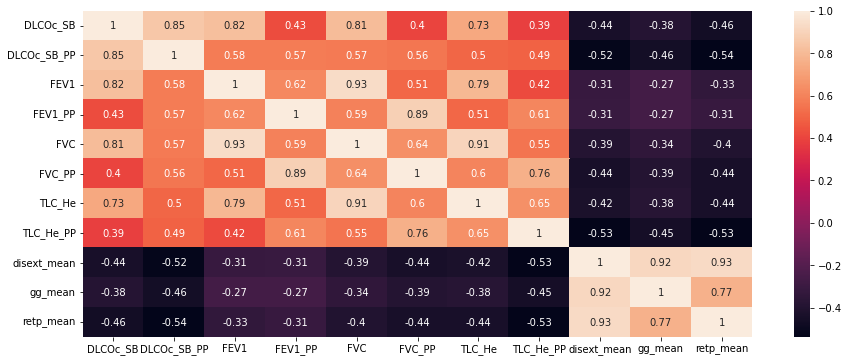

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))

sns.heatmap(df_valid.corr(), ax=ax, annot=True)